#import

In [13]:
# from google.colab import drive

# drive.mount('/content/drive')

In [1]:
import os
import gc
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from tensorflow.keras.backend import clear_session

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder, MinMaxScaler
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Input, Dense, LSTM, Bidirectional, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam, RMSprop, SGD, Adagrad
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint
from tensorflow.keras.losses import SparseCategoricalCrossentropy, CategoricalCrossentropy
from tensorflow.keras.regularizers import l2
from tensorflow.keras.utils import to_categorical
from tensorflow.keras import backend as K
from scipy.interpolate import interp1d



#Augmentasi

In [2]:



# 1. Skala ukuran tubuh (misal orang lebih tinggi atau pendek)
def scale_keypoints(keypoints, scale_range=(0.8, 1.2)):
    scale = np.random.uniform(*scale_range)
    return keypoints * scale

# 2. Cermin (mirror) → cocok untuk gerakan tangan kanan vs kiri
def mirror_keypoints(keypoints):
    mirrored = keypoints.copy()
    mirrored[:, ::3] *= -1  # Balik sumbu X
    return mirrored

# 3. Rotasi kecil (±15 derajat) → menangani pose miring
def rotate_keypoints(keypoints, angle_range=(-15, 15)):
    angle = np.radians(np.random.uniform(*angle_range))
    cos, sin = np.cos(angle), np.sin(angle)
    rotation_matrix = np.array([[cos, -sin], [sin, cos]])
    rotated = keypoints.copy()

    for i in range(0, keypoints.shape[1], 3):
        xy = rotated[:, i:i+2]
        rotated[:, i:i+2] = np.dot(xy, rotation_matrix)
    return rotated

# 4. Tambahkan noise kecil ke keypoint → variasi posisi
def jitter_keypoints(keypoints, noise_std=0.02):
    jitter = np.random.normal(0, noise_std, keypoints.shape)
    return keypoints + jitter

# 5. Masking keypoint → handle kasus sebagian tubuh tak terdeteksi
def mask_keypoints(keypoints, mask_ratio=0.2):
    masked = keypoints.copy()
    total_points = keypoints.shape[1] // 3
    num_mask = int(total_points * mask_ratio)
    mask_indices = np.random.choice(total_points, num_mask, replace=False)
    for idx in mask_indices:
        masked[:, idx*3:idx*3+3] = 0
    return masked

# 6. Time warping → menangani gerakan lebih cepat/lambat
def time_warp_keypoints(keypoints, warp_range=(0.8, 1.2)):
    original_len = keypoints.shape[0]
    factor = np.random.uniform(*warp_range)
    new_len = max(5, int(original_len * factor))  # Jaga agar minimal 5 frame
    x_old = np.linspace(0, 1, original_len)
    x_new = np.linspace(0, 1, new_len)
    f = interp1d(x_old, keypoints, axis=0, kind='linear')
    warped = f(x_new)

    # resample balik ke panjang awal
    return resample_keypoints(warped, original_len)

# Resample helper
def resample_keypoints(keypoints, target_len):
    x_old = np.linspace(0, 1, keypoints.shape[0])
    x_new = np.linspace(0, 1, target_len)
    f = interp1d(x_old, keypoints, axis=0, kind='linear')
    return f(x_new)

# 7. Balik urutan (berguna jika ada gerakan yang simetris)
def reverse_sequence(keypoints):
    return keypoints[::-1]


# 9. Augmentasi gabungan
def augment_keypoints_all(keypoints):
    return [
         scale_keypoints(keypoints.copy()),
         mirror_keypoints(keypoints.copy()),
         rotate_keypoints(keypoints.copy()),
         jitter_keypoints(keypoints.copy()),
         reverse_sequence(keypoints.copy())
    ]


#Load Data

In [3]:


# Fungsi load data
def load_data(folder_path, sequence_length=30, augment=False):
    X, y = [], []
    labels = os.listdir(folder_path)

    for label in labels:
        class_path = os.path.join(folder_path, label)
        if not os.path.isdir(class_path):
            continue

        for file in os.listdir(class_path):
            if file.endswith('.csv'):
                df = pd.read_csv(os.path.join(class_path, file))
                keypoints = df[[f'{axis}_{i}' for i in range(23, 33) for axis in ['x', 'y', 'z']]]
                keypoints = keypoints.dropna()

                keypoints_np = keypoints.values

                # Selalu proses, bahkan jika < sequence_length
                if len(keypoints_np) < sequence_length:
                    pad_len = sequence_length - len(keypoints_np)
                    pad_array = np.zeros((pad_len, keypoints_np.shape[1]))
                    keypoints_np = np.vstack([keypoints_np, pad_array])
                else:
                    keypoints_np = keypoints_np[:sequence_length]

                X.append(keypoints_np)
                y.append(label)

                if augment:
                    augmented_list = augment_keypoints_all(keypoints_np)
                    for aug in augmented_list:
                        X.append(aug)
                        y.append(label)

    return np.array(X), np.array(y)

# Load seluruh data (sekarang sudah gabung antara train dan test)
X_all, y_all = load_data("E:\\Kuliah\SMSTR 7\\Methopen\\data_klasifikasi_revisi\\data_klasifikasi_gerakan_silat_csv_(gabungan)\\data_klasifikasi_gerakan_silat_csv\\data_2", augment=False)

# Split 80% train, 20% sisanya (val + test)
X_train_raw, X_temp, y_train_raw, y_temp = train_test_split(
    X_all, y_all, test_size=0.2, random_state=42, stratify=y_all
)

# Split lagi 20% sisanya jadi 10% val dan 10% test
X_val, X_test, y_val, y_test = train_test_split(
    X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp
)
# Cetak distribusi label
print("Distribusi label y_train:", pd.Series(y_train_raw).value_counts())
print("\nDistribusi label y_val:", pd.Series(y_val).value_counts())
print("\nDistribusi label y_test:", pd.Series(y_test).value_counts())


Distribusi label y_train: kuda-kuda    112
langkah      112
tendang      112
dtype: int64

Distribusi label y_val: kuda-kuda    14
tendang      14
langkah      14
dtype: int64

Distribusi label y_test: kuda-kuda    15
langkah      14
tendang      14
dtype: int64


#Augentasi data Train

In [5]:
X_augmented = []
y_augmented = []
for x, y in zip(X_train_raw, y_train_raw):
    X_augmented.append(x)
    y_augmented.append(y)
    for aug in augment_keypoints_all(x.copy()):
        X_augmented.append(aug)
        y_augmented.append(y)

X_train = np.array(X_augmented)
y_train = np.array(y_augmented)

print("Distribusi label y_train setelah augmentasi:", pd.Series(y_train).value_counts())

Distribusi label y_train setelah augmentasi: kuda-kuda    672
langkah      672
tendang      672
dtype: int64


#Normalisasi Data

In [6]:


# Normalisasi
scaler = MinMaxScaler()

X_train_flat = X_train.reshape(-1, X_train.shape[-1])
X_val_flat = X_val.reshape(-1, X_val.shape[-1])
X_test_flat = X_test.reshape(-1, X_test.shape[-1])

X_train_scaled = scaler.fit_transform(X_train_flat).reshape(X_train.shape)
X_val_scaled = scaler.transform(X_val_flat).reshape(X_val.shape)
X_test_scaled = scaler.transform(X_test_flat).reshape(X_test.shape)


#encoding

In [7]:

# Label Encoding + One-Hot Encoding
label_encoder = LabelEncoder()

y_train_enc = label_encoder.fit_transform(y_train)
y_val_enc = label_encoder.transform(y_val)
y_test_enc = label_encoder.transform(y_test)

y_train_cat = to_categorical(y_train_enc)
y_val_cat = to_categorical(y_val_enc)
y_test_cat = to_categorical(y_test_enc)

num_classes = y_train_cat.shape[1]

print(f"Jumlah kelas: {num_classes}")


Jumlah kelas: 3


#configurasi

In [20]:

# === Definisikan Semua Configurations dari Excel ===
configurations = pd.DataFrame([
    {'Model Kofigurasi': 'tr_a_fl', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'Adam', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'rs_r_fl', 'Fungsi aktivasi(LSTM/Dense)': 'relu/softmax', 'optimizer': 'RMSprop', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.0001},
    {'Model Kofigurasi': 'rs_g_ce', 'Fungsi aktivasi(LSTM/Dense)': 'relu/softmax', 'optimizer': 'Adagrad', 'Loss function': 'CategoricalCrossentropy', 'Reg(L2)': 0.00001},
    {'Model Kofigurasi': 'tr_s_ce', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'SGD', 'Loss function': 'CategoricalCrossentropy', 'Reg(L2)': 0.0001},
    {'Model Kofigurasi': 'rr_a_fl', 'Fungsi aktivasi(LSTM/Dense)': 'relu/relu', 'optimizer': 'Adam', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'rr_r_ce', 'Fungsi aktivasi(LSTM/Dense)': 'relu/relu', 'optimizer': 'RMSprop', 'Loss function': 'CategoricalCrossentropy', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'tr_a_fl', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'Adam', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.0001},
    {'Model Kofigurasi': 'tr_a_ce', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'Adam', 'Loss function': 'CategoricalCrossentropy', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'tr_a_ce', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'Adam', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.00001},
    {'Model Kofigurasi': 'tr_a_fl', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'Adam', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'tr_r_fl', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'RMSprop', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.001},
    {'Model Kofigurasi': 'tr_s_fl', 'Fungsi aktivasi(LSTM/Dense)': 'tanh/relu', 'optimizer': 'SGD', 'Loss function': 'Focal Loss', 'Reg(L2)': 0.001},
])


#kode dan model

In [21]:
# --- Custom Focal Loss ---
def focal_loss(gamma=2., alpha=0.25):
    def focal_loss_fixed(y_true, y_pred):
        epsilon = K.epsilon()
        y_pred = K.clip(y_pred, epsilon, 1. - epsilon)
        cross_entropy = -y_true * K.log(y_pred)
        weight = alpha * K.pow(1 - y_pred, gamma)
        loss = weight * cross_entropy
        return K.sum(loss, axis=1)
    return focal_loss_fixed

results = []
best_val_acc = 0.0
best_model_path = 'best_model7_2.h5'
best_history = None
# === Loop untuk Training Berdasarkan Config ===
for idx, config in configurations.iterrows():
    print(f"\nTraining Experiment {idx+1}: {config['Fungsi aktivasi(LSTM/Dense)']} | {config['optimizer']} | {config['Loss function']} | Reg: {config['Reg(L2)']}")

    clear_session()
    gc.collect()

    ACTIVATION_LSTM, ACTIVATION_DENSE = config['Fungsi aktivasi(LSTM/Dense)'].split('/')
    OPTIMIZER_NAME = config['optimizer']
    LOSS_FUNCTION = config['Loss function']
    REGULARIZATION = float(str(config['Reg(L2)']).replace(',', '.'))

    model = Sequential([
        Input(shape=(X_train_scaled.shape[1], X_train_scaled.shape[2])),

        Bidirectional(LSTM(128, return_sequences=True, activation=ACTIVATION_LSTM.strip(),
                           kernel_regularizer=l2(REGULARIZATION),
                           recurrent_regularizer=l2(REGULARIZATION))),
        BatchNormalization(),
        Dropout(0.2),

        Bidirectional(LSTM(128, return_sequences=False, activation=ACTIVATION_LSTM.strip(),
                           kernel_regularizer=l2(REGULARIZATION),
                           recurrent_regularizer=l2(REGULARIZATION))),
        BatchNormalization(),
        Dropout(0.2),

        Dense(32, activation=ACTIVATION_DENSE.strip(), kernel_regularizer=l2(REGULARIZATION)),
        Dropout(0.2),

        Dense(num_classes, activation='softmax')
    ])

    # Optimizer
    if OPTIMIZER_NAME.lower() == 'adam':
        optimizer = Adam(learning_rate=0.0006629053703185273) if idx == 0 else Adam()
    elif OPTIMIZER_NAME.lower() == 'rmsprop':
        optimizer = RMSprop()
    elif OPTIMIZER_NAME.lower() == 'sgd':
        optimizer = SGD()
    elif OPTIMIZER_NAME.lower() == 'adagrad':
        optimizer = Adagrad()
    else:
        raise ValueError(f"Unknown optimizer: {OPTIMIZER_NAME}")

    # Loss Function
    if 'Focal' in LOSS_FUNCTION:
        loss = focal_loss(gamma=2.0, alpha=0.25)
    elif 'Sparse' in LOSS_FUNCTION:
        loss = SparseCategoricalCrossentropy()
    elif 'Cat' in LOSS_FUNCTION:
        loss = CategoricalCrossentropy()
    else:
        raise ValueError(f"Unknown loss function: {LOSS_FUNCTION}")

    model.compile(optimizer=optimizer, loss=loss, metrics=['accuracy'])

    early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)
    checkpoint = ModelCheckpoint('temp_model7_2.h5', monitor='val_accuracy', save_best_only=True, save_weights_only=False, verbose=0)

    history = model.fit(X_train_scaled, y_train_cat,
                        validation_data=(X_val_scaled, y_val_cat),
                        epochs=100, batch_size=32, verbose=0,
     #                    callbacks=[early_stopping, checkpoint]
                        callbacks=[checkpoint]
                       )

    # Load best model
    model = load_model('temp_model7_2.h5', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})

    train_acc = history.history['accuracy'][-1]
    val_acc = history.history['val_accuracy'][-1]
    train_loss = history.history['loss'][-1]
    val_loss = history.history['val_loss'][-1]

    results.append({
        'Percobaan': idx + 1,
        'Model': config['Model Kofigurasi'],
        'Train Accuracy': train_acc,
        'Val Accuracy': val_acc,
        'Train Loss': train_loss,
        'Val Loss': val_loss
    })
  
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        model.save(best_model_path)
        best_history = history  # simpan history dari model terbaik



Training Experiment 1: tanh/relu | Adam | Focal Loss | Reg: 0.001


C:\Users\user\anaconda3\Lib\site-packages\keras\src\engine\training.py:3079: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(



Training Experiment 2: relu/softmax | RMSprop | Focal Loss | Reg: 0.0001

Training Experiment 3: relu/softmax | Adagrad | CategoricalCrossentropy | Reg: 1e-05

Training Experiment 4: tanh/relu | SGD | CategoricalCrossentropy | Reg: 0.0001

Training Experiment 5: relu/relu | Adam | Focal Loss | Reg: 0.001

Training Experiment 6: relu/relu | RMSprop | CategoricalCrossentropy | Reg: 0.001

Training Experiment 7: tanh/relu | Adam | Focal Loss | Reg: 0.0001

Training Experiment 8: tanh/relu | Adam | CategoricalCrossentropy | Reg: 0.001

Training Experiment 9: tanh/relu | Adam | Focal Loss | Reg: 1e-05

Training Experiment 10: tanh/relu | Adam | Focal Loss | Reg: 0.001

Training Experiment 11: tanh/relu | RMSprop | Focal Loss | Reg: 0.001

Training Experiment 12: tanh/relu | SGD | Focal Loss | Reg: 0.001



=== Hasil Evaluasi Setiap Percobaan ===

    Percobaan    Model  Train Accuracy  Val Accuracy  Train Loss  Val Loss
0           1  tr_a_fl        0.902778      0.666667    0.039821  0.143860
1           2  rs_r_fl        0.948909      0.619048    0.022171  0.226339
2           3  rs_g_ce        0.622520      0.547619    0.924471  0.986571
3           4  tr_s_ce        0.938988      0.761905    0.288276  1.077003
4           5  rr_a_fl        0.887897      0.619048    0.052669  0.187008
5           6  rr_r_ce        0.954365      0.761905    0.215781  0.837712
6           7  tr_a_fl        0.937996      0.595238    0.032826  0.157659
7           8  tr_a_ce        0.963790      0.833333    0.278636  1.347200
8           9  tr_a_ce        0.987103      0.642857    0.013217  0.234043
9          10  tr_a_fl        0.892857      0.690476    0.044907  0.168563
10         11  tr_r_fl        0.875496      0.595238    0.043100  0.218069
11         12  tr_s_fl        0.824405      0.714286    1.

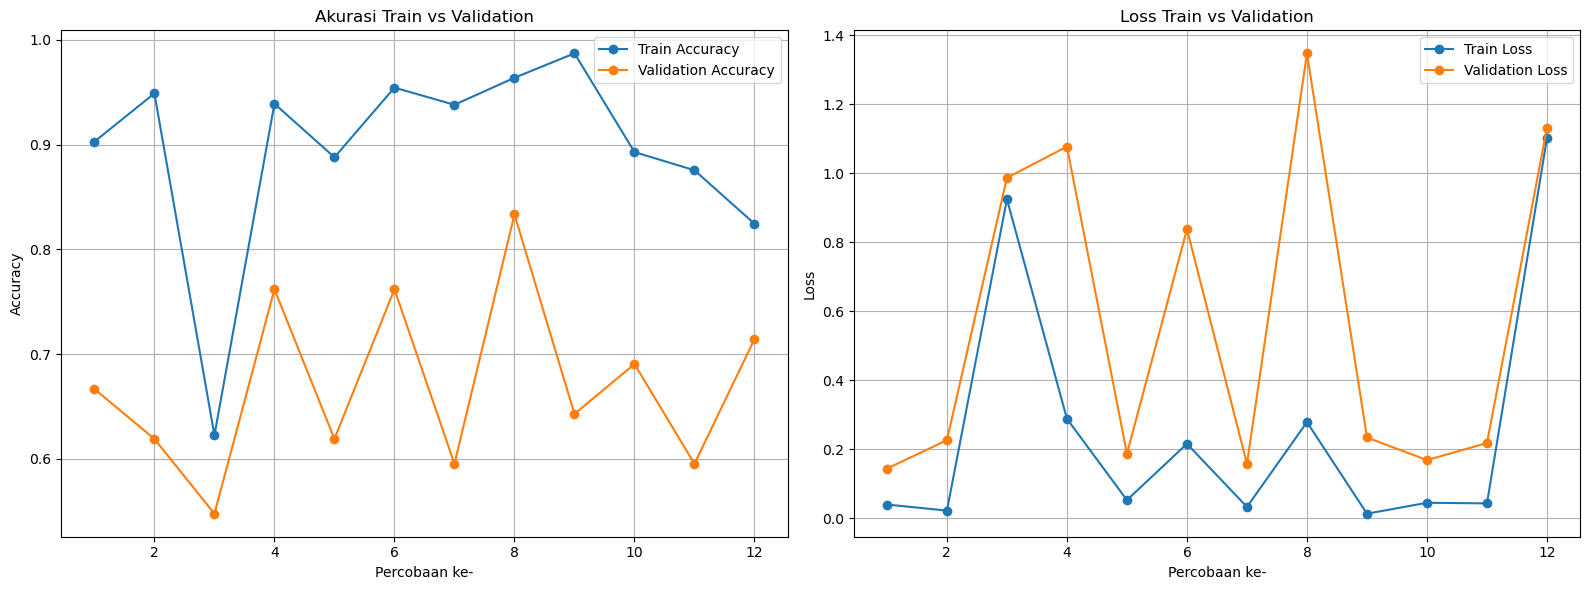


=== Percobaan Terbaik ===
Percobaan ke-8
Train Accuracy: 0.9638
Val Accuracy: 0.8333
Model: tr_a_ce


In [22]:
# === Save Hasil Evaluasi ===
results_df = pd.DataFrame(results)
results_df.to_csv('hasil_percobaan.csv', index=False)

# === Tampilkan Semua Hasil Percobaan ===
print("\n=== Hasil Evaluasi Setiap Percobaan ===\n")
print(results_df)

# === Plot Accuracy dan Loss ===
plt.figure(figsize=(16, 6))

# Accuracy
plt.subplot(1, 2, 1)
plt.plot(results_df['Percobaan'], results_df['Train Accuracy'], marker='o', label='Train Accuracy')
plt.plot(results_df['Percobaan'], results_df['Val Accuracy'], marker='o', label='Validation Accuracy')
plt.title('Akurasi Train vs Validation')
plt.xlabel('Percobaan ke-')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

# Loss
plt.subplot(1, 2, 2)
plt.plot(results_df['Percobaan'], results_df['Train Loss'], marker='o', label='Train Loss')
plt.plot(results_df['Percobaan'], results_df['Val Loss'], marker='o', label='Validation Loss')
plt.title('Loss Train vs Validation')
plt.xlabel('Percobaan ke-')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

# === Evaluasi Model Terbaik ===
best_trial = results_df.loc[results_df['Val Accuracy'].idxmax()]
print("\n=== Percobaan Terbaik ===")
print(f"Percobaan ke-{best_trial['Percobaan']}")
print(f"Train Accuracy: {best_trial['Train Accuracy']:.4f}")
print(f"Val Accuracy: {best_trial['Val Accuracy']:.4f}")
print(f"Model: {best_trial['Model']}")

# Load Model
best_model = load_model('best_model7_2.h5', custom_objects={'focal_loss_fixed': focal_loss(gamma=2.0, alpha=0.25)})



2/2 [==============================] - 1s 29ms/step
=== Classification Report - Validation Set ===
              precision    recall  f1-score   support

   kuda-kuda       0.82      1.00      0.90        14
     langkah       0.83      0.71      0.77        14
     tendang       0.85      0.79      0.81        14

    accuracy                           0.83        42
   macro avg       0.83      0.83      0.83        42
weighted avg       0.83      0.83      0.83        42



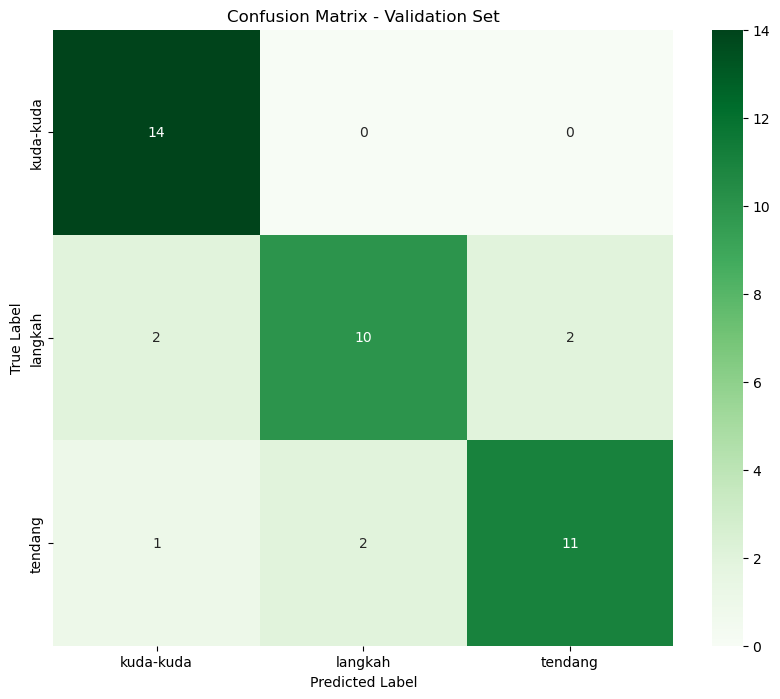

2/2 [==============================] - 0s 22ms/step
=== Classification Report - Testing Set ===
              precision    recall  f1-score   support

   kuda-kuda       0.87      0.87      0.87        15
     langkah       0.93      0.93      0.93        14
     tendang       0.93      0.93      0.93        14

    accuracy                           0.91        43
   macro avg       0.91      0.91      0.91        43
weighted avg       0.91      0.91      0.91        43



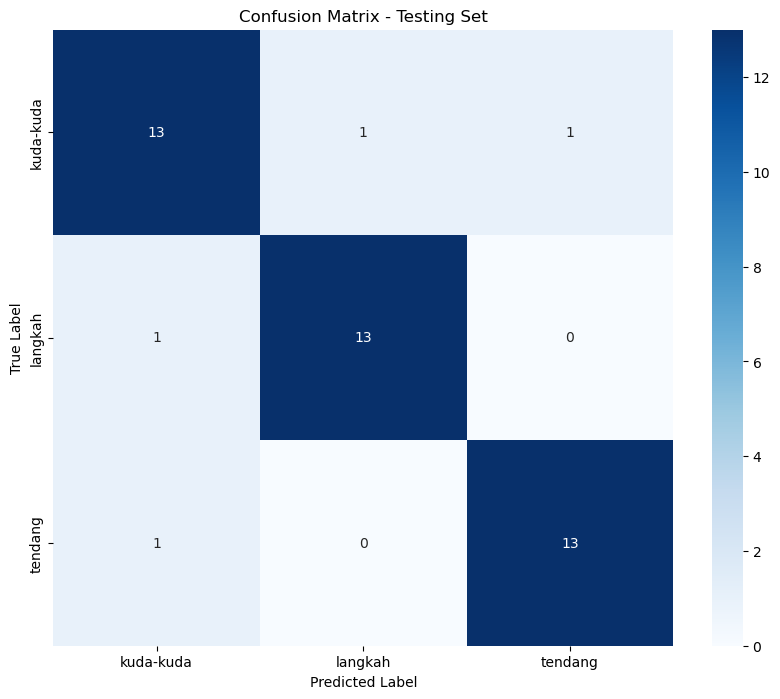

In [23]:
# === Prediksi data validasi ===
y_val_pred_probs = best_model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val_cat, axis=1)

# === Confusion Matrix dan Classification Report untuk Validasi ===
print("=== Classification Report - Validation Set ===")
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_))

cm_val = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# === Prediksi data testing ===
y_test_pred_probs = best_model.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)

# === Confusion Matrix dan Classification Report untuk Testing ===
print("=== Classification Report - Testing Set ===")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()


Hasil Prediksi Per File:
                               Nama File Kelas Sebenarnya Kelas Prediksi
0       tambah_kuda-kuda10_keypoints.csv        kuda-kuda      kuda-kuda
1       tambah_kuda-kuda11_keypoints.csv        kuda-kuda        langkah
2       tambah_kuda-kuda12_keypoints.csv        kuda-kuda      kuda-kuda
3       tambah_kuda-kuda13_keypoints.csv        kuda-kuda      kuda-kuda
4       tambah_kuda-kuda14_keypoints.csv        kuda-kuda      kuda-kuda
5       tambah_kuda-kuda15_keypoints.csv        kuda-kuda      kuda-kuda
6       tambah_kuda-kuda16_keypoints.csv        kuda-kuda        langkah
7       tambah_kuda-kuda17_keypoints.csv        kuda-kuda      kuda-kuda
8        tambah_kuda-kuda1_keypoints.csv        kuda-kuda      kuda-kuda
9        tambah_kuda-kuda2_keypoints.csv        kuda-kuda      kuda-kuda
10       tambah_kuda-kuda3_keypoints.csv        kuda-kuda      kuda-kuda
11       tambah_kuda-kuda4_keypoints.csv        kuda-kuda      kuda-kuda
12       tambah_kuda-kuda5

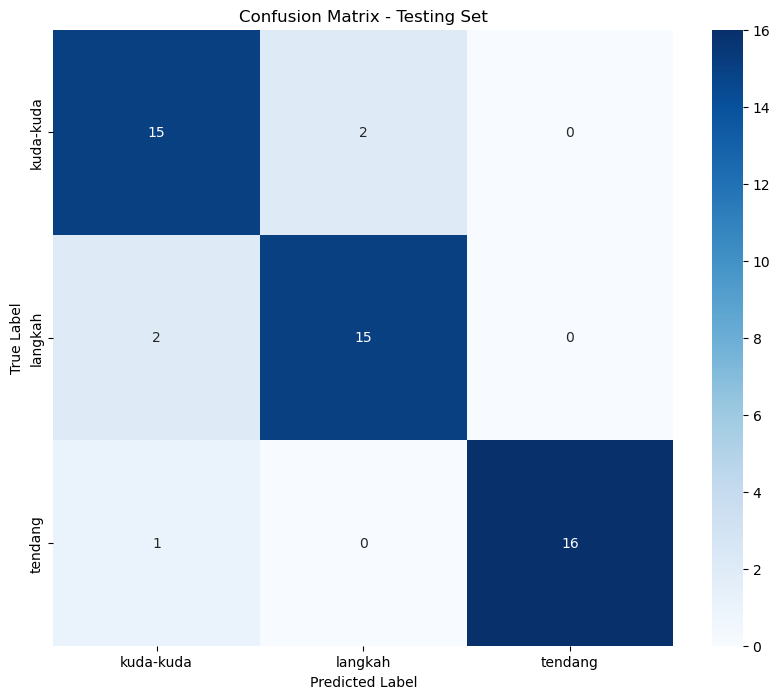


Confusion Matrix (DataFrame):
           kuda-kuda  langkah  tendang
kuda-kuda         15        2        0
langkah            2       15        0
tendang            1        0       16


In [24]:
# Load model
best_model

# Folder test
test_folder = "E:\\Kuliah\\SMSTR 7\\Methopen\\data_klasifikasi_revisi\\data_klasifikasi_gerakan_silat_csv\\test"

# Konstanta
sequence_length = 30  # Sesuaikan dengan nilai yang digunakan saat training
feature_columns = [f'{axis}_{i}' for i in range(23, 33) for axis in ['x', 'y', 'z']]  # Kolom keypoint (x_23..z_32)

# Inisialisasi variabel hasil
true_labels = []
pred_labels = []
file_names = []

# Loop folder per kelas
for class_name in os.listdir(test_folder):
    class_path = os.path.join(test_folder, class_name)
    if not os.path.isdir(class_path):
        continue

    for file_name in os.listdir(class_path):
        if not file_name.endswith('.csv'):
            continue

        file_path = os.path.join(class_path, file_name)
        df = pd.read_csv(file_path)

        # Cek apakah kolom keypoint lengkap
        if not all(col in df.columns for col in feature_columns):
            print(f"File {file_name} kolomnya tidak lengkap, dilewati.")
            continue

        # Ambil hanya kolom keypoint yang digunakan
        keypoints = df[feature_columns].dropna()
        keypoints_np = keypoints.values

        # Padding atau pemotongan data agar sesuai dengan sequence_length
        if len(keypoints_np) < sequence_length:
            pad_len = sequence_length - len(keypoints_np)
            pad_array = np.zeros((pad_len, keypoints_np.shape[1]))
            keypoints_np = np.vstack([keypoints_np, pad_array])
        else:
            keypoints_np = keypoints_np[:sequence_length]

        # Normalisasi dan reshape data
        keypoints_flat = keypoints_np.reshape(-1, keypoints_np.shape[-1])  # (sequence_length, 30)
        keypoints_scaled = scaler.transform(keypoints_flat).reshape(1, sequence_length, -1)  # (1, sequence_length, 30)

        # Prediksi kelas
        prediction = model.predict(keypoints_scaled, verbose=0)
        pred_class = np.argmax(prediction, axis=1)[0]
        pred_label = label_encoder.inverse_transform([pred_class])[0]

        # Simpan hasil prediksi
        true_labels.append(class_name)
        pred_labels.append(pred_label)
        file_names.append(file_name)

# Buat DataFrame hasil prediksi
results_df = pd.DataFrame({
    'Nama File': file_names,
    'Kelas Sebenarnya': true_labels,
    'Kelas Prediksi': pred_labels
})

# Tampilkan hasil prediksi per file
print("Hasil Prediksi Per File:")
print(results_df)

# Simpan hasil ke file CSV
results_df.to_csv('hasil_prediksi_per_file.csv', index=False)

# Tampilkan Classification Report
print("=== Classification Report - Testing Set ===")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

# Buat dan tampilkan Confusion Matrix
cm_test = confusion_matrix(true_labels, pred_labels, labels=label_encoder.classes_)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# Tampilkan Confusion Matrix dalam bentuk DataFrame
conf_df = pd.DataFrame(cm_test, index=label_encoder.classes_, columns=label_encoder.classes_)
print("\nConfusion Matrix (DataFrame):")
print(conf_df)


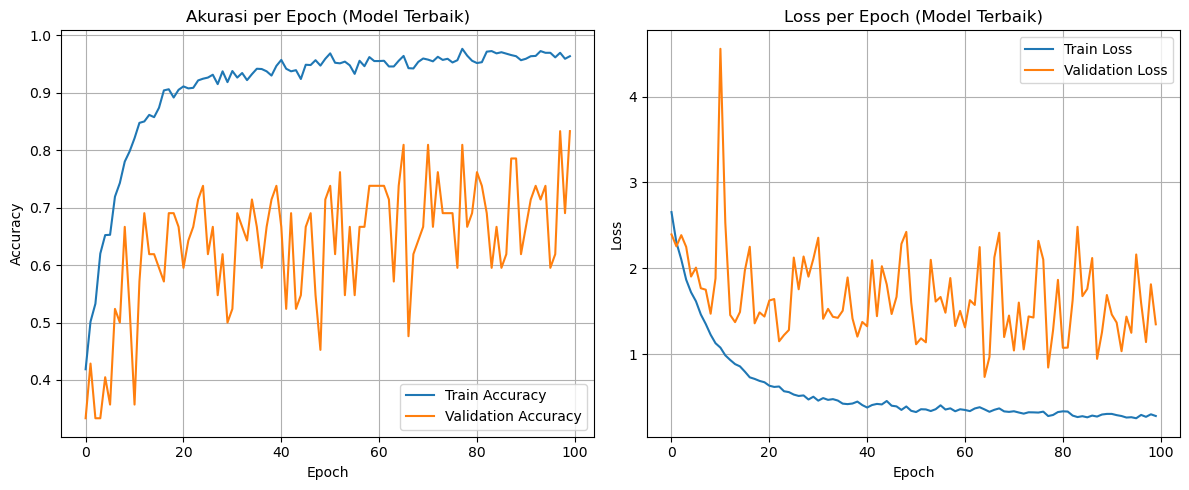

In [25]:
# === Plot history dari model terbaik ===
if best_history:
    plt.figure(figsize=(12, 5))

    # Plot Accuracy
    plt.subplot(1, 2, 1)
    plt.plot(best_history.history['accuracy'], label='Train Accuracy')
    plt.plot(best_history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Akurasi per Epoch (Model Terbaik)')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.grid(True)

    # Plot Loss
    plt.subplot(1, 2, 2)
    plt.plot(best_history.history['loss'], label='Train Loss')
    plt.plot(best_history.history['val_loss'], label='Validation Loss')
    plt.title('Loss per Epoch (Model Terbaik)')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.grid(True)

    plt.tight_layout()
    plt.show()
else:
    print("Tidak ada history yang tersimpan dari model terbaik.")


In [26]:
import os
print(os.getcwd())

C:\Users\user


2/2 [==============================] - 2s 15ms/step
=== Classification Report - Validation Set ===
              precision    recall  f1-score   support

   kuda-kuda       0.76      0.93      0.84        14
     langkah       0.77      0.71      0.74        14
     tendang       0.83      0.71      0.77        14

    accuracy                           0.79        42
   macro avg       0.79      0.79      0.78        42
weighted avg       0.79      0.79      0.78        42



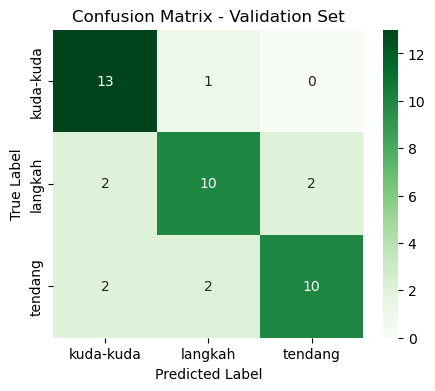

2/2 [==============================] - 0s 10ms/step
=== Classification Report - Testing Set ===
              precision    recall  f1-score   support

   kuda-kuda       0.86      0.80      0.83        15
     langkah       0.87      0.93      0.90        14
     tendang       0.93      0.93      0.93        14

    accuracy                           0.88        43
   macro avg       0.88      0.89      0.88        43
weighted avg       0.88      0.88      0.88        43



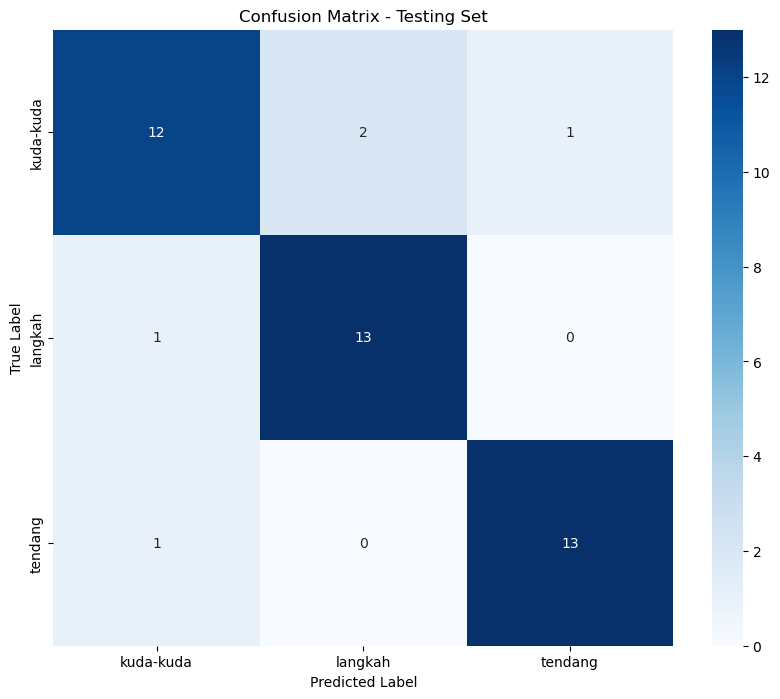

In [8]:
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# === Load model dari file .h5 ===
model_path = "C:\\Users\\user\\best_model7_2.h5" # Ganti dengan path aslinya
model = load_model(model_path)

# === Prediksi data validasi ===
y_val_pred_probs = model.predict(X_val_scaled)
y_val_pred = np.argmax(y_val_pred_probs, axis=1)
y_val_true = np.argmax(y_val_cat, axis=1)

# === Confusion Matrix dan Classification Report untuk Validasi ===
print("=== Classification Report - Validation Set ===")
print(classification_report(y_val_true, y_val_pred, target_names=label_encoder.classes_))

cm_val = confusion_matrix(y_val_true, y_val_pred)
plt.figure(figsize=(5, 4))
sns.heatmap(cm_val, annot=True, fmt="d", cmap="Greens",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Validation Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()

# === Prediksi data testing ===
y_test_pred_probs = model.predict(X_test_scaled)
y_test_pred = np.argmax(y_test_pred_probs, axis=1)
y_test_true = np.argmax(y_test_cat, axis=1)

# === Confusion Matrix dan Classification Report untuk Testing ===
print("=== Classification Report - Testing Set ===")
print(classification_report(y_test_true, y_test_pred, target_names=label_encoder.classes_))

cm_test = confusion_matrix(y_test_true, y_test_pred)
plt.figure(figsize=(10, 8))
sns.heatmap(cm_test, annot=True, fmt="d", cmap="Blues",
            xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.title("Confusion Matrix - Testing Set")
plt.xlabel("Predicted Label")
plt.ylabel("True Label")
plt.show()
